In [11]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
     

In [12]:

image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
     

In [15]:
import os

DATA_DIR = 'C:/Users/shrey/Major Projectfinal/dataset'
print(os.listdir(DATA_DIR))

['test', 'test.csv', 'train', 'train.csv']


In [16]:
print(os.listdir(DATA_DIR+'/train')[:10])

['train_0001.jpg', 'train_0002.jpg', 'train_0003.jpg', 'train_0004.jpg', 'train_0005.jpg', 'train_0006.jpg', 'train_0007.jpg', 'train_0008.jpg', 'train_0009.jpg', 'train_0010.jpg']


In [17]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
     

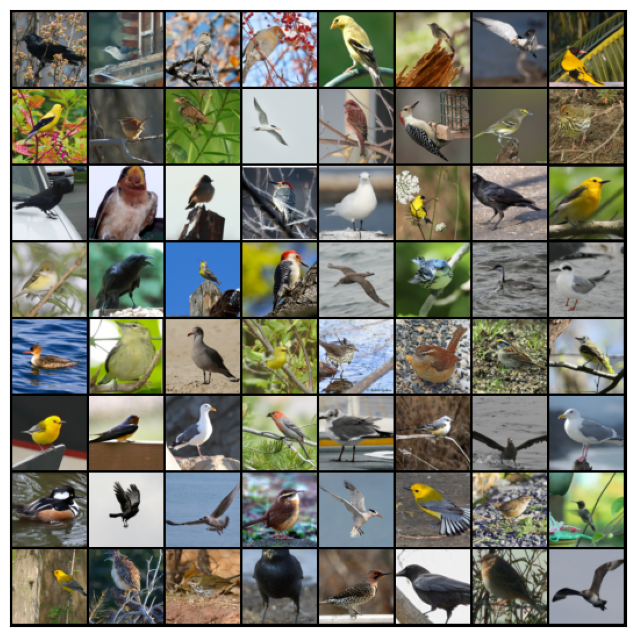

In [18]:

import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
     

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
     

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
     

show_batch(train_dl)

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


In [20]:
def get_default_device():
    """Always return CPU"""
    return torch.device('cpu')


In [26]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [27]:

device = get_default_device()
device

device(type='cpu')

In [28]:

train_dl = DeviceDataLoader(train_dl, device)
     

import torch.nn as nn

In [29]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())
     

discriminator = to_device(discriminator, device)
     

latent_size = 600

torch.Size([128, 3, 64, 64])


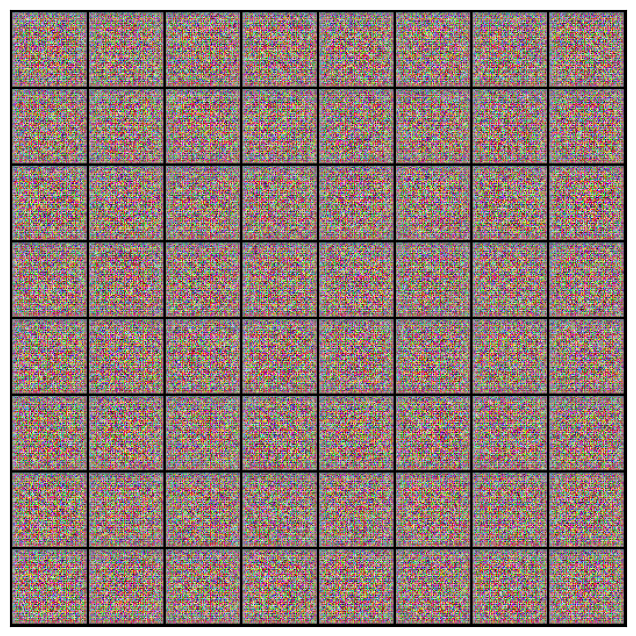

In [30]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)
     

xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [31]:
generator = to_device(generator, device)

In [32]:

def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [33]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [34]:

from torchvision.utils import save_image
     

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
     

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


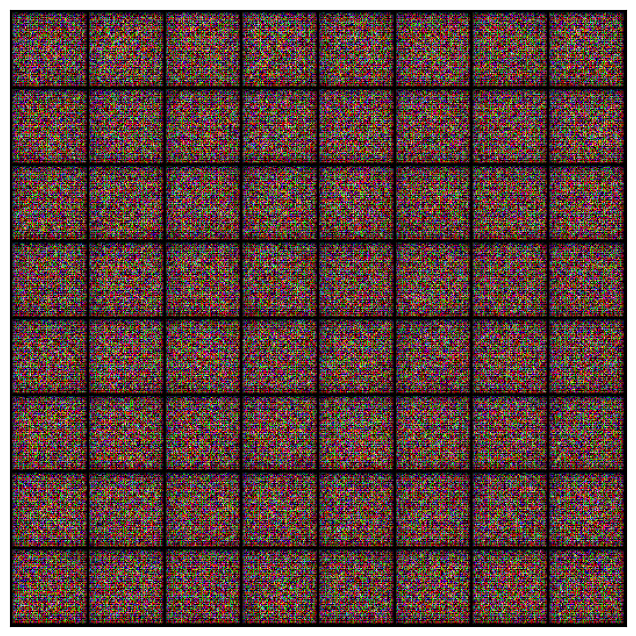

In [35]:

fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
     

save_samples(0, fixed_latent)

In [36]:

from tqdm.notebook import tqdm
import torch.nn.functional as F
     

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [37]:
lr = 0.0001
epochs = 600

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [1/600], loss_g: 5.2883, loss_d: 0.4908, real_score: 0.7561, fake_score: 0.1606
Saving generated-images-0001.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [2/600], loss_g: 6.7853, loss_d: 0.1260, real_score: 0.9411, fake_score: 0.0597
Saving generated-images-0002.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [3/600], loss_g: 7.2485, loss_d: 0.0702, real_score: 0.9698, fake_score: 0.0379
Saving generated-images-0003.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [4/600], loss_g: 6.3247, loss_d: 0.0914, real_score: 0.9330, fake_score: 0.0191
Saving generated-images-0004.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [5/600], loss_g: 6.9875, loss_d: 0.0141, real_score: 0.9913, fake_score: 0.0053
Saving generated-images-0005.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [6/600], loss_g: 7.2541, loss_d: 0.0313, real_score: 0.9845, fake_score: 0.0154
Saving generated-images-0006.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [7/600], loss_g: 7.1093, loss_d: 0.0189, real_score: 0.9915, fake_score: 0.0103
Saving generated-images-0007.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [8/600], loss_g: 7.0215, loss_d: 0.0241, real_score: 0.9863, fake_score: 0.0101
Saving generated-images-0008.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [9/600], loss_g: 7.6120, loss_d: 0.0189, real_score: 0.9919, fake_score: 0.0107
Saving generated-images-0009.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [10/600], loss_g: 7.0002, loss_d: 0.0125, real_score: 0.9949, fake_score: 0.0073
Saving generated-images-0010.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [11/600], loss_g: 6.9597, loss_d: 0.0139, real_score: 0.9940, fake_score: 0.0078
Saving generated-images-0011.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [12/600], loss_g: 3.0222, loss_d: 0.2987, real_score: 0.8610, fake_score: 0.1292
Saving generated-images-0012.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [13/600], loss_g: 4.7838, loss_d: 0.1484, real_score: 0.9568, fake_score: 0.0946
Saving generated-images-0013.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [14/600], loss_g: 5.7035, loss_d: 0.1341, real_score: 0.9336, fake_score: 0.0581
Saving generated-images-0014.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [15/600], loss_g: 4.8842, loss_d: 0.1762, real_score: 0.8890, fake_score: 0.0487
Saving generated-images-0015.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [16/600], loss_g: 4.4979, loss_d: 0.0751, real_score: 0.9417, fake_score: 0.0128
Saving generated-images-0016.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [17/600], loss_g: 6.0953, loss_d: 0.1358, real_score: 0.8930, fake_score: 0.0075
Saving generated-images-0017.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [18/600], loss_g: 4.3118, loss_d: 0.2125, real_score: 0.8473, fake_score: 0.0295
Saving generated-images-0018.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [19/600], loss_g: 4.3140, loss_d: 0.3652, real_score: 0.7471, fake_score: 0.0183
Saving generated-images-0019.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [20/600], loss_g: 7.6714, loss_d: 0.0510, real_score: 0.9563, fake_score: 0.0006
Saving generated-images-0020.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [21/600], loss_g: 5.0341, loss_d: 0.5293, real_score: 0.8697, fake_score: 0.2821
Saving generated-images-0021.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [22/600], loss_g: 2.0687, loss_d: 0.3382, real_score: 0.7819, fake_score: 0.0474
Saving generated-images-0022.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [23/600], loss_g: 4.5099, loss_d: 0.1285, real_score: 0.9221, fake_score: 0.0292
Saving generated-images-0023.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [24/600], loss_g: 3.6568, loss_d: 0.1839, real_score: 0.8786, fake_score: 0.0385
Saving generated-images-0024.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [25/600], loss_g: 5.8047, loss_d: 0.1134, real_score: 0.9498, fake_score: 0.0418
Saving generated-images-0025.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [26/600], loss_g: 4.8863, loss_d: 0.4814, real_score: 0.8645, fake_score: 0.1965
Saving generated-images-0026.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [27/600], loss_g: 2.9211, loss_d: 0.6503, real_score: 0.7238, fake_score: 0.2005
Saving generated-images-0027.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [28/600], loss_g: 4.4373, loss_d: 0.1525, real_score: 0.9494, fake_score: 0.0850
Saving generated-images-0028.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [29/600], loss_g: 2.5318, loss_d: 0.2013, real_score: 0.9118, fake_score: 0.0874
Saving generated-images-0029.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [30/600], loss_g: 4.8525, loss_d: 0.1623, real_score: 0.9768, fake_score: 0.1236
Saving generated-images-0030.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [31/600], loss_g: 7.4576, loss_d: 0.3611, real_score: 0.9691, fake_score: 0.2511
Saving generated-images-0031.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [32/600], loss_g: 4.0753, loss_d: 0.3175, real_score: 0.8526, fake_score: 0.1162
Saving generated-images-0032.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [33/600], loss_g: 6.4422, loss_d: 0.5568, real_score: 0.9327, fake_score: 0.3335
Saving generated-images-0033.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [34/600], loss_g: 3.4432, loss_d: 0.3527, real_score: 0.8283, fake_score: 0.0896
Saving generated-images-0034.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [35/600], loss_g: 3.4301, loss_d: 0.4026, real_score: 0.7480, fake_score: 0.0244
Saving generated-images-0035.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [36/600], loss_g: 4.2410, loss_d: 0.1713, real_score: 0.9593, fake_score: 0.1128
Saving generated-images-0036.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [37/600], loss_g: 4.6832, loss_d: 0.1511, real_score: 0.9552, fake_score: 0.0919
Saving generated-images-0037.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [38/600], loss_g: 4.0952, loss_d: 0.1640, real_score: 0.9544, fake_score: 0.1045
Saving generated-images-0038.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [39/600], loss_g: 3.9399, loss_d: 0.2219, real_score: 0.8557, fake_score: 0.0502
Saving generated-images-0039.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [40/600], loss_g: 4.0493, loss_d: 0.1848, real_score: 0.9829, fake_score: 0.1451
Saving generated-images-0040.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [41/600], loss_g: 3.8121, loss_d: 0.1244, real_score: 0.9664, fake_score: 0.0816
Saving generated-images-0041.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [42/600], loss_g: 2.9958, loss_d: 0.1616, real_score: 0.9677, fake_score: 0.1055
Saving generated-images-0042.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [43/600], loss_g: 6.0411, loss_d: 0.3048, real_score: 0.9618, fake_score: 0.2128
Saving generated-images-0043.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [44/600], loss_g: 4.4476, loss_d: 0.1947, real_score: 0.8879, fake_score: 0.0637
Saving generated-images-0044.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [45/600], loss_g: 2.0869, loss_d: 0.0733, real_score: 0.9595, fake_score: 0.0283
Saving generated-images-0045.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [46/600], loss_g: 3.2816, loss_d: 0.2385, real_score: 0.8921, fake_score: 0.0975
Saving generated-images-0046.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [47/600], loss_g: 3.9620, loss_d: 0.1784, real_score: 0.9249, fake_score: 0.0872
Saving generated-images-0047.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [48/600], loss_g: 4.6507, loss_d: 0.1363, real_score: 0.9120, fake_score: 0.0376
Saving generated-images-0048.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [49/600], loss_g: 5.1976, loss_d: 0.2883, real_score: 0.9322, fake_score: 0.1721
Saving generated-images-0049.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [50/600], loss_g: 4.8675, loss_d: 0.1362, real_score: 0.9760, fake_score: 0.0994
Saving generated-images-0050.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [51/600], loss_g: 3.1873, loss_d: 0.6754, real_score: 0.6040, fake_score: 0.0060
Saving generated-images-0051.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [52/600], loss_g: 5.4170, loss_d: 0.1929, real_score: 0.9861, fake_score: 0.1498
Saving generated-images-0052.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [53/600], loss_g: 5.1225, loss_d: 0.1922, real_score: 0.9587, fake_score: 0.1247
Saving generated-images-0053.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [54/600], loss_g: 4.6687, loss_d: 0.1739, real_score: 0.9165, fake_score: 0.0768
Saving generated-images-0054.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [55/600], loss_g: 5.3856, loss_d: 0.3621, real_score: 0.9232, fake_score: 0.2246
Saving generated-images-0055.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [56/600], loss_g: 8.1476, loss_d: 0.6310, real_score: 0.9819, fake_score: 0.4021
Saving generated-images-0056.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [57/600], loss_g: 4.5128, loss_d: 0.0736, real_score: 0.9568, fake_score: 0.0267
Saving generated-images-0057.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [58/600], loss_g: 2.4939, loss_d: 1.2813, real_score: 0.3980, fake_score: 0.0038
Saving generated-images-0058.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [59/600], loss_g: 5.5803, loss_d: 0.4325, real_score: 0.9556, fake_score: 0.2957
Saving generated-images-0059.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [60/600], loss_g: 0.8113, loss_d: 3.0109, real_score: 0.0834, fake_score: 0.0004
Saving generated-images-0060.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [61/600], loss_g: 6.4177, loss_d: 0.8092, real_score: 0.8393, fake_score: 0.4120
Saving generated-images-0061.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [62/600], loss_g: 3.8071, loss_d: 0.2386, real_score: 0.8925, fake_score: 0.1019
Saving generated-images-0062.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [63/600], loss_g: 1.7826, loss_d: 0.4756, real_score: 0.6832, fake_score: 0.0380
Saving generated-images-0063.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [64/600], loss_g: 3.6542, loss_d: 0.3285, real_score: 0.8347, fake_score: 0.0986
Saving generated-images-0064.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [65/600], loss_g: 4.3577, loss_d: 0.1289, real_score: 0.9520, fake_score: 0.0722
Saving generated-images-0065.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [66/600], loss_g: 4.6622, loss_d: 0.1420, real_score: 0.9092, fake_score: 0.0410
Saving generated-images-0066.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [67/600], loss_g: 3.9357, loss_d: 0.1953, real_score: 0.8553, fake_score: 0.0289
Saving generated-images-0067.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [68/600], loss_g: 4.0993, loss_d: 0.2668, real_score: 0.8948, fake_score: 0.1299
Saving generated-images-0068.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [69/600], loss_g: 6.0918, loss_d: 0.1414, real_score: 0.8928, fake_score: 0.0165
Saving generated-images-0069.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [70/600], loss_g: 5.3770, loss_d: 0.1921, real_score: 0.9656, fake_score: 0.1351
Saving generated-images-0070.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [71/600], loss_g: 5.2580, loss_d: 0.4063, real_score: 0.9083, fake_score: 0.2353
Saving generated-images-0071.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [72/600], loss_g: 4.8556, loss_d: 0.2858, real_score: 0.8734, fake_score: 0.1198
Saving generated-images-0072.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [73/600], loss_g: 5.0735, loss_d: 0.2506, real_score: 0.9271, fake_score: 0.1477
Saving generated-images-0073.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [74/600], loss_g: 4.4482, loss_d: 0.1574, real_score: 0.9122, fake_score: 0.0561
Saving generated-images-0074.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [75/600], loss_g: 4.2832, loss_d: 0.2144, real_score: 0.8755, fake_score: 0.0615
Saving generated-images-0075.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [76/600], loss_g: 4.6971, loss_d: 0.0961, real_score: 0.9447, fake_score: 0.0359
Saving generated-images-0076.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [77/600], loss_g: 4.9544, loss_d: 0.1563, real_score: 0.9250, fake_score: 0.0653
Saving generated-images-0077.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [78/600], loss_g: 5.4930, loss_d: 0.2430, real_score: 0.9611, fake_score: 0.1607
Saving generated-images-0078.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [79/600], loss_g: 5.1219, loss_d: 0.3099, real_score: 0.9702, fake_score: 0.1976
Saving generated-images-0079.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [80/600], loss_g: 4.6303, loss_d: 0.1722, real_score: 0.8753, fake_score: 0.0259
Saving generated-images-0080.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [81/600], loss_g: 4.0532, loss_d: 0.2067, real_score: 0.9194, fake_score: 0.1061
Saving generated-images-0081.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [82/600], loss_g: 6.5478, loss_d: 0.1365, real_score: 0.9044, fake_score: 0.0244
Saving generated-images-0082.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [83/600], loss_g: 5.0309, loss_d: 0.1815, real_score: 0.9378, fake_score: 0.0860
Saving generated-images-0083.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [84/600], loss_g: 5.5200, loss_d: 0.1587, real_score: 0.9704, fake_score: 0.1102
Saving generated-images-0084.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [85/600], loss_g: 4.5819, loss_d: 0.2496, real_score: 0.8131, fake_score: 0.0146
Saving generated-images-0085.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [86/600], loss_g: 4.9894, loss_d: 0.0702, real_score: 0.9524, fake_score: 0.0180
Saving generated-images-0086.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [87/600], loss_g: 4.2021, loss_d: 0.1983, real_score: 0.8912, fake_score: 0.0719
Saving generated-images-0087.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [88/600], loss_g: 4.0252, loss_d: 0.2149, real_score: 0.9202, fake_score: 0.1063
Saving generated-images-0088.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [89/600], loss_g: 4.9558, loss_d: 0.1205, real_score: 0.9418, fake_score: 0.0546
Saving generated-images-0089.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [90/600], loss_g: 3.2750, loss_d: 0.0905, real_score: 0.9774, fake_score: 0.0621
Saving generated-images-0090.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [91/600], loss_g: 3.8754, loss_d: 0.1258, real_score: 0.9343, fake_score: 0.0517
Saving generated-images-0091.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [92/600], loss_g: 2.7571, loss_d: 0.2552, real_score: 0.8405, fake_score: 0.0466
Saving generated-images-0092.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [93/600], loss_g: 3.6875, loss_d: 0.1609, real_score: 0.8841, fake_score: 0.0263
Saving generated-images-0093.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [94/600], loss_g: 4.9397, loss_d: 0.2186, real_score: 0.9631, fake_score: 0.1565
Saving generated-images-0094.png


  0%|          | 0/24 [00:00<?, ?it/s]